# Customer Churn

### 1. Import necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import shap
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from xgboost import XGBClassifier

### 2. Load and Inspect the Dataset

In [2]:
csv_file_path = 'data_ecommerce_customer_churn.csv'
df = pd.read_csv(csv_file_path, encoding='latin1', on_bad_lines='skip')

# Inspect the first few rows
print("\nFirst few rows of data:\n", df.head())

# Summary Statistics
# Check summary statistics for each column
print("\nSummary Statistics:\n", df.describe())

# Check Data Types and Missing Values
# Get info on data types and missing values
print("\nDataset Information:\n", df.info())


First few rows of data:
    Tenure  WarehouseToHome  NumberOfDeviceRegistered    PreferedOrderCat  \
0    15.0             29.0                         4  Laptop & Accessory   
1     7.0             25.0                         4              Mobile   
2    27.0             13.0                         3  Laptop & Accessory   
3    20.0             25.0                         4             Fashion   
4    30.0             15.0                         4              Others   

   SatisfactionScore MaritalStatus  NumberOfAddress  Complain  \
0                  3        Single                2         0   
1                  1       Married                2         0   
2                  1       Married                5         0   
3                  3      Divorced                7         0   
4                  4        Single                8         0   

   DaySinceLastOrder  CashbackAmount  Churn  
0                7.0          143.32      0  
1                7.0          129.

### 3. Handle Missing Values

In [3]:
print("\nMissing Values Before Cleaning:\n", df.isnull().sum())
numerical_columns = ['Tenure', 'WarehouseToHome', 'DaySinceLastOrder']

# Fill missing numerical values with the median
for column in numerical_columns:
    median_value = df[column].median()
    df[column].fillna(median_value, inplace=True)

# Verify that there are no missing values left
print("\nMissing Values After Cleaning:\n", df.isnull().sum())

# Remove Outliers for Numerical Columns
# Define a function to remove outliers using the IQR method
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Apply outlier removal for numerical columns
for column in numerical_columns + ['CashbackAmount', 'NumberOfDeviceRegistered', 'NumberOfAddress']:
    df = remove_outliers(df, column)

# Encode Categorical Variables
# Perform one-hot encoding for categorical columns
categorical_columns = ['PreferedOrderCat', 'MaritalStatus']
df_encoded = pd.get_dummies(df, columns=categorical_columns, drop_first=True)



Missing Values Before Cleaning:
 Tenure                      194
WarehouseToHome             169
NumberOfDeviceRegistered      0
PreferedOrderCat              0
SatisfactionScore             0
MaritalStatus                 0
NumberOfAddress               0
Complain                      0
DaySinceLastOrder           213
CashbackAmount                0
Churn                         0
dtype: int64

Missing Values After Cleaning:
 Tenure                      0
WarehouseToHome             0
NumberOfDeviceRegistered    0
PreferedOrderCat            0
SatisfactionScore           0
MaritalStatus               0
NumberOfAddress             0
Complain                    0
DaySinceLastOrder           0
CashbackAmount              0
Churn                       0
dtype: int64


C:\Users\milto\AppData\Local\Temp\ipykernel_20440\1783177162.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[column].fillna(median_value, inplace=True)


### 4. PreProcess Data

In [4]:
# Feature Scaling
# Scale numerical features using StandardScaler
scaler = StandardScaler()
features_to_scale = ['Tenure', 'WarehouseToHome', 'NumberOfDeviceRegistered', 'NumberOfAddress',
                     'DaySinceLastOrder', 'CashbackAmount', 'SatisfactionScore']
df_encoded[features_to_scale] = scaler.fit_transform(df_encoded[features_to_scale])

# Derived Features
# Add additional derived features for deeper insights
df_encoded['AvgCashbackPerInteraction'] = df_encoded['CashbackAmount'] / (df_encoded['NumberOfDeviceRegistered'] + 1)
df_encoded['ComplaintsPerTenure'] = df_encoded['Complain'] / (df_encoded['Tenure'] + 1)
df_encoded['EngagementIntensity'] = df_encoded['NumberOfDeviceRegistered'] + df_encoded['SatisfactionScore'] + df_encoded['Complain']

In [5]:
# Drop Highly Correlated Features
# Drop features with high correlations (greater than 0.85) to avoid redundancy
correlation_matrix = df_encoded.corr()
high_corr = [(col1, col2) for (col1, col2), val in correlation_matrix.unstack().items() if col1 != col2 and abs(val) > 0.85]
for col1, col2 in high_corr:
    if col2 in df_encoded.columns:
        df_encoded.drop(columns=[col2], inplace=True)

In [6]:
# Prepare Features and Target Variable, Balance Dataset
# Define features (X) and target variable (y)
X = df_encoded.drop(columns=['Churn'])
y = df_encoded['Churn']

# Use SMOTE and undersampling to balance classes
over = SMOTE(sampling_strategy=0.5, random_state=42)
under = RandomUnderSampler(sampling_strategy=0.7, random_state=42)
pipeline = Pipeline(steps=[('o', over), ('u', under)])
X_balanced, y_balanced = pipeline.fit_resample(X, y)

# Inspect the class distribution after balancing
print("\nClass distribution after balancing:\n", y_balanced.value_counts())



Class distribution after balancing:
 Churn
0    1934
1    1354
Name: count, dtype: int64


### 5. Feature Importance

In [7]:
# Feature Importance Using Random Forest
# Train a RandomForest model to get feature importance
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_balanced, y_balanced)
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': rf.feature_importances_}).sort_values(by='Importance', ascending=False)
print("\nFeature Importances:\n", feature_importance_df)


Feature Importances:
                                 Feature  Importance
0                                Tenure    0.230901
15                  ComplaintsPerTenure    0.120809
7                        CashbackAmount    0.099263
14            AvgCashbackPerInteraction    0.084521
16                  EngagementIntensity    0.073175
6                     DaySinceLastOrder    0.069549
1                       WarehouseToHome    0.062828
4                       NumberOfAddress    0.060370
3                     SatisfactionScore    0.049439
13                 MaritalStatus_Single    0.037846
5                              Complain    0.035824
2              NumberOfDeviceRegistered    0.019539
9   PreferedOrderCat_Laptop & Accessory    0.017141
11        PreferedOrderCat_Mobile Phone    0.014024
12                MaritalStatus_Married    0.013149
10              PreferedOrderCat_Mobile    0.009170
8              PreferedOrderCat_Grocery    0.002451


### 6. Train and Evaluate the Model

In [8]:
# Train Logistic Regression with Class Weight Balancing
# Split balanced dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)
log_reg_balanced = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
log_reg_balanced.fit(X_train, y_train)

# Evaluate Logistic Regression Model
y_pred_balanced = log_reg_balanced.predict(X_test)
print("\nLogistic Regression Confusion Matrix:\n", confusion_matrix(y_test, y_pred_balanced))
print("\nLogistic Regression Classification Report:\n", classification_report(y_test, y_pred_balanced))



Logistic Regression Confusion Matrix:
 [[336  70]
 [ 46 206]]

Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.83      0.85       406
           1       0.75      0.82      0.78       252

    accuracy                           0.82       658
   macro avg       0.81      0.82      0.82       658
weighted avg       0.83      0.82      0.83       658



In [9]:
# Adjust Decision Threshold
# Change decision threshold to 0.4 to assess model performance
y_probs = log_reg_balanced.predict_proba(X_test)[:, 1]
new_threshold = 0.4
y_pred_threshold = (y_probs >= new_threshold).astype(int)
print("\nConfusion Matrix with Adjusted Threshold:\n", confusion_matrix(y_test, y_pred_threshold))
print("\nClassification Report with Adjusted Threshold:\n", classification_report(y_test, y_pred_threshold))



Confusion Matrix with Adjusted Threshold:
 [[306 100]
 [ 36 216]]

Classification Report with Adjusted Threshold:
               precision    recall  f1-score   support

           0       0.89      0.75      0.82       406
           1       0.68      0.86      0.76       252

    accuracy                           0.79       658
   macro avg       0.79      0.81      0.79       658
weighted avg       0.81      0.79      0.80       658



In [10]:
# Train XGBoost Classifier
# Train an XGBoost classifier with scale_pos_weight to address class imbalance
xgb_clf = XGBClassifier(objective='binary:logistic', scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]), random_state=42)
xgb_clf.fit(X_train, y_train)

# Evaluate XGBoost Classifier
y_pred_xgb = xgb_clf.predict(X_test)
print("\nXGBoost Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))
print("\nXGBoost Classification Report:\n", classification_report(y_test, y_pred_xgb))



XGBoost Confusion Matrix:
 [[379  27]
 [ 12 240]]

XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.93      0.95       406
           1       0.90      0.95      0.92       252

    accuracy                           0.94       658
   macro avg       0.93      0.94      0.94       658
weighted avg       0.94      0.94      0.94       658



### 7. SHAP Analysis

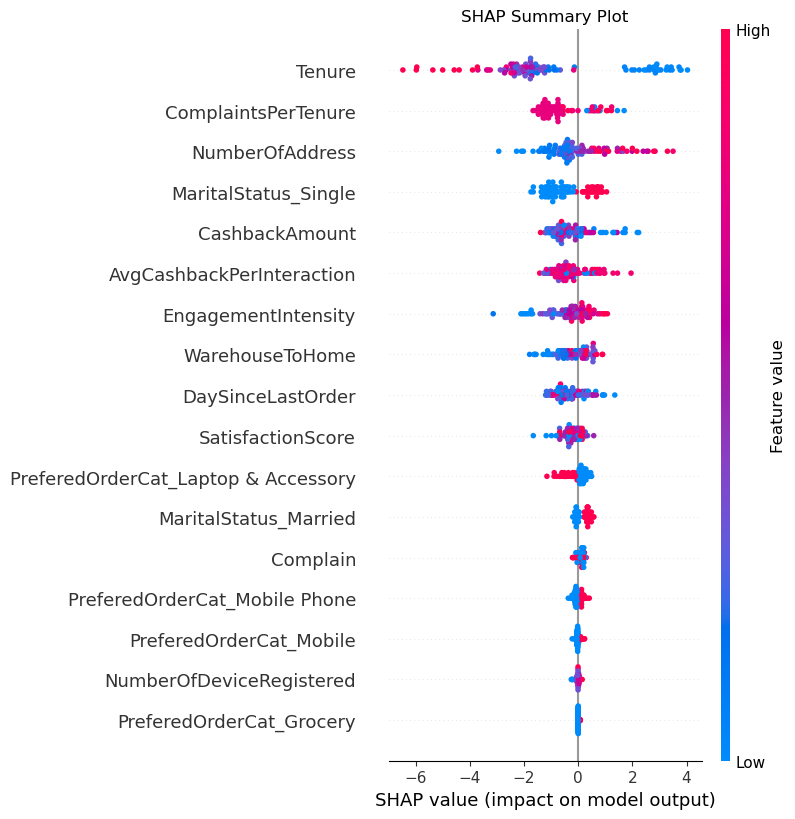

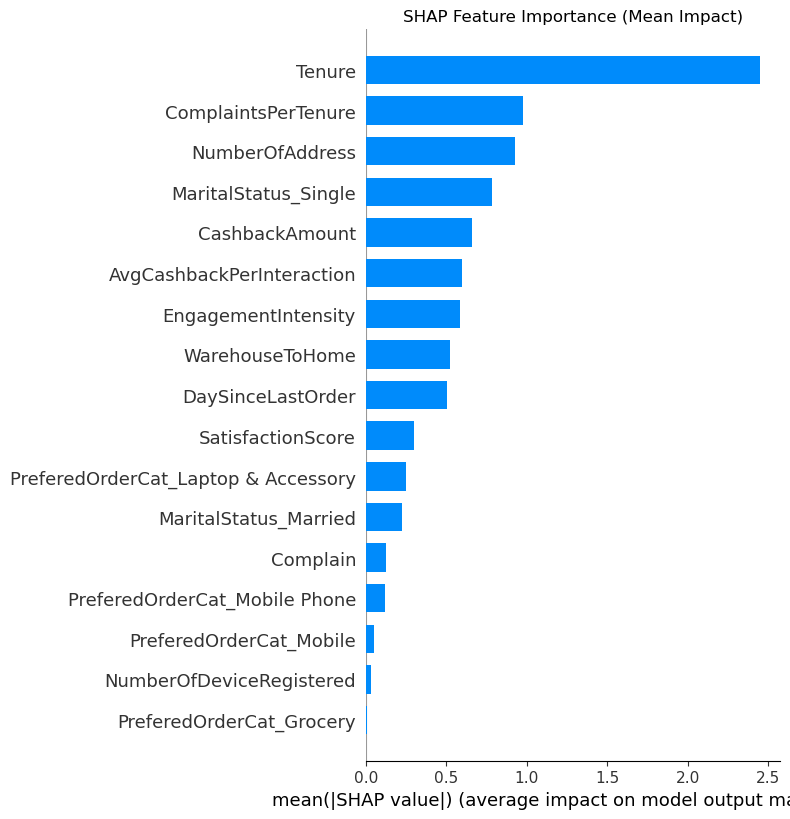

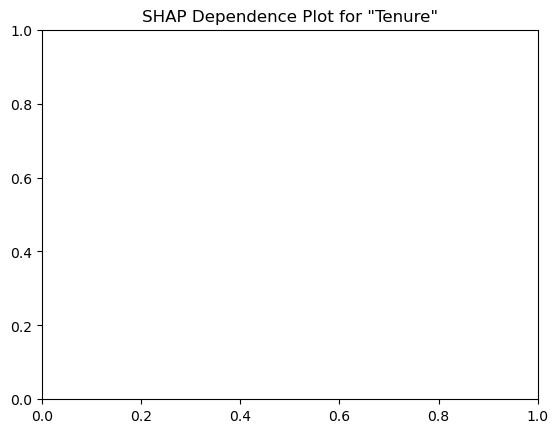

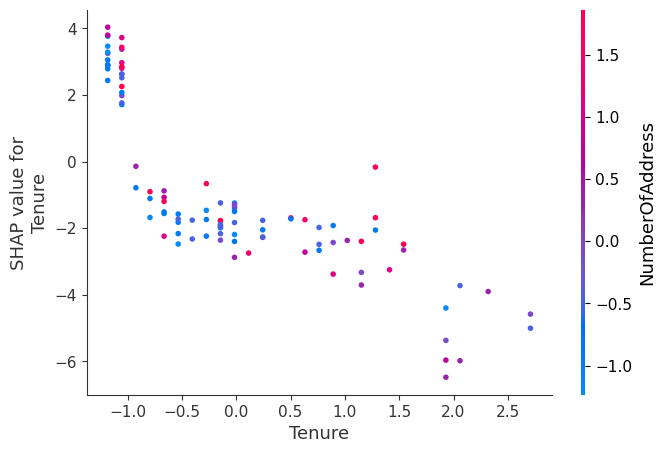

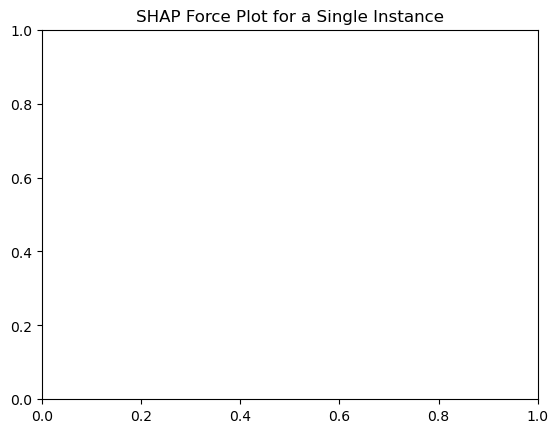

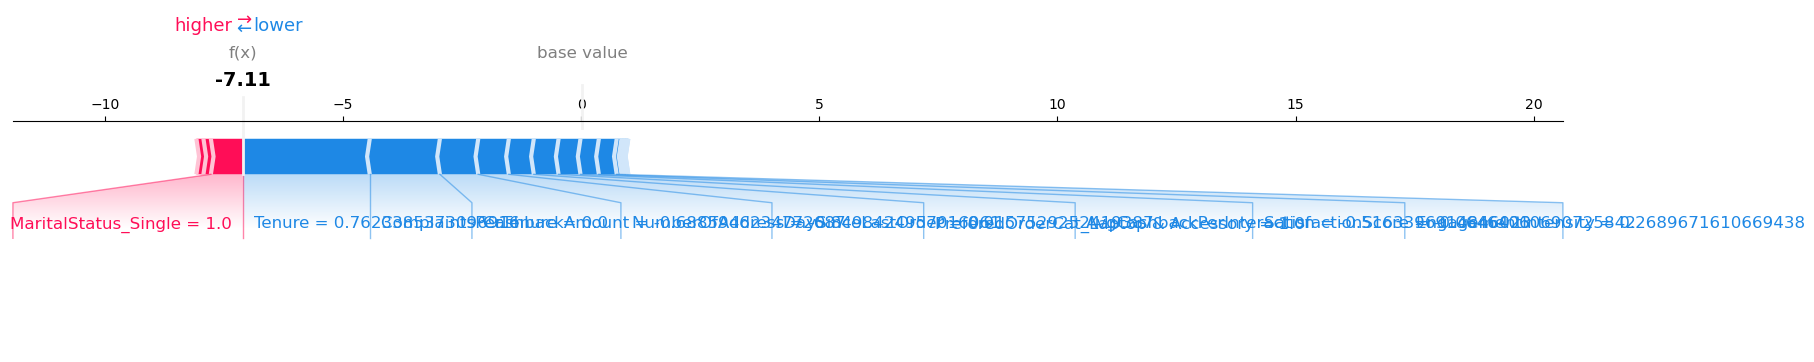

In [11]:
# Align columns with model's expected features
expected_features = xgb_clf.get_booster().feature_names
X_final = df_encoded[expected_features].apply(pd.to_numeric, errors='coerce').fillna(0)
X_subset = X_final.head(100)  # Use first 100 rows for SHAP analysis

# SHAP Explainer
explainer = shap.TreeExplainer(xgb_clf)
shap_values = explainer.shap_values(X_subset)

# SHAP Summary Plot
plt.title('SHAP Summary Plot')
shap.summary_plot(shap_values, X_subset)

# SHAP Bar Plot for Feature Impact
plt.title('SHAP Feature Importance (Mean Impact)')
shap.summary_plot(shap_values, X_subset, plot_type="bar")

# SHAP Dependence Plot for 'Tenure'
plt.title('SHAP Dependence Plot for "Tenure"')
shap.dependence_plot('Tenure', shap_values, X_subset)

# SHAP Force Plot for a Single Instance
shap.initjs()
row_to_explain = 0
plt.title('SHAP Force Plot for a Single Instance')
shap.force_plot(explainer.expected_value, shap_values[row_to_explain], X_subset.iloc[row_to_explain], matplotlib=True)